# DashLab Induction Assignment 2025

## SysML Level 3


This assignment may appear long because of the size of the notebook, but it truly isn’t.

You are not expected to complete the entire assignment in one sitting. It has been intentionally designed so that you can work through it in parts and at your own pace.

The goal of this assignment is not to test your coding ability or how quickly you can brute-force solutions. Instead, it is meant to assess how well you understand a wide range of technical concepts without getting overwhelmed along the way.

We recognize that these topics are not easy — take your time, explore, focus on comprehension and most importantly enjoy the learning process.

At DashLab, we look for students who are able to understand diverse subjects and meaningfully connect them across domains — yadaya.

IT IS THEREFORE HIGHLY discouraged to use hosted LLMs to copy-paste answers and bypass the learning process (Claude, Gemini, ChatGPT, DeepSeek, etc.), especially for this assignment.


---
P.S. You may however use any LLM which you can run **locally** on your laptop and do let us know if you used any :D


You might have heard about [ollama](https://ollama.com/) - a simple tool to allow you to run various such LLMs on your local device (and very fast if you have a gaming laptop).



###Best of luck, you've got this!





.
.

# Which local LLM did you use?
if you used any - no compulsion



In [1]:
# Answer here: gemma3:4b

# Ran with ollama on Kaggle. Technically, can be run locally, but potato :wilt:.

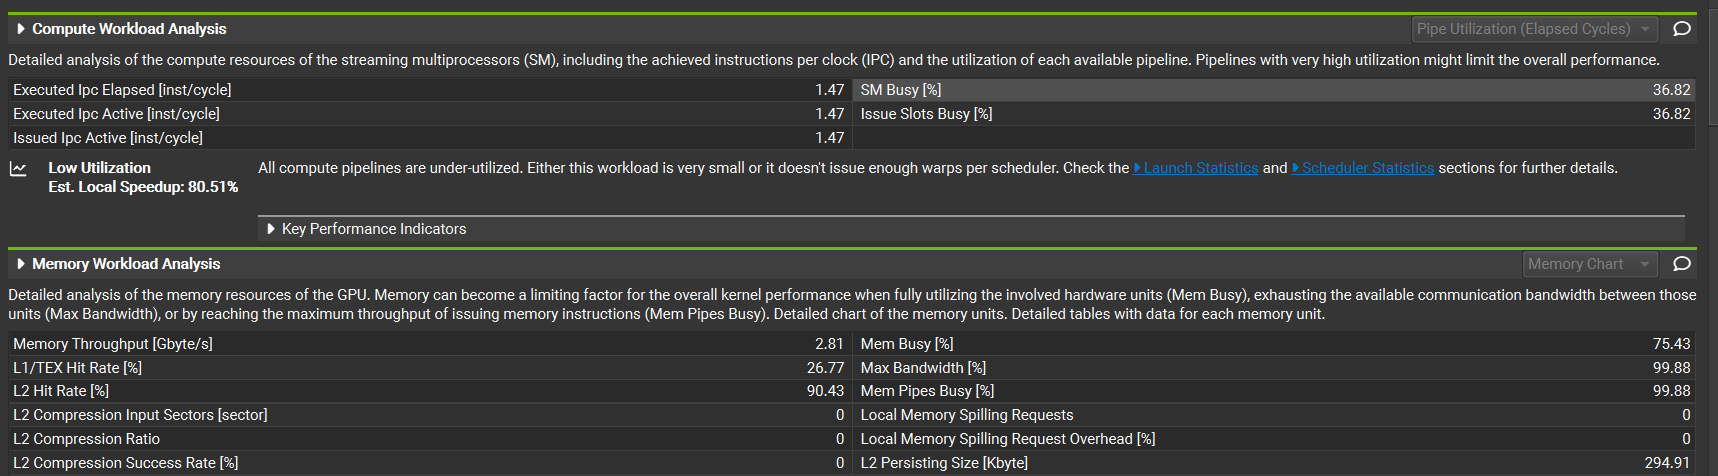

The above image is a screenshot of profiling done on a CUDA kernel’s runtime. Please do not be intimidated by all the different fields — just focus on two:

*  SM Busy%
*  Max Bandwidth%


### Question: Is this workload I/O bound or Compute bound?
Why do you think so? Look up what the two fields mean in GPU terms



In [2]:
# Your Answer:

############### YOUR ANSWER STARTS HERE #################

# SM Busy ~ %time of active instruction execution
# Max Bandwidth ~ max data transfer rate

# I/O bound as it's limited/bottlenecked by memory bandwidth rather than computational capacity.

############### YOUR ANSWER ENDS HERE #################

Fun fact: During the intial prefill stage of running a large model, the workload is generally compute-bound — matrix multiplications are large and the GPU cores stay busy.

But during the decode stage, each new token requires repeatedly reading previously stored values (KV cache). The math is small, but the data movement is frequent. So the GPU becomes memory-bandwidth-bound, not core-limited.

This leads to an important question:

If memory bandwidth becomes the bottleneck, how do we make things faster?



A few ideas immediately come up:


*   Can we reduce how much data we move?
*   Can we store model parameters more compactly?
*   Can we fit more into faster on-chip memory (caches / registers)?
*   Can we reduce the precision without breaking correctness?



In other words:

Do we really need to store each weight as a 16-bit or 32-bit floating-point number?

That idea is called Quantisation.

Quantisation reduces the precision used to represent weights (and sometimes activations). Instead of FP16/FP32, values can be stored in INT8, INT4, or other compressed formats — with scaling applied to approximate the original range.

Key point:
We are trading excess precision for higher performance and this brings us to your Level 3 Assignment for SysML!

###Important Note
We intially had a part 1 for this assignment which had the focus of quantisation only as a build up to our assignment, doing this assignment first can make it easier to proceed, this assignment will be treated as a Bonus as well - [See here](https://colab.research.google.com/drive/1sCny958Gjbv0Dalw3Aly4CVswF9G8_aF?usp=sharing)



#Let's learn about LLMs

You will learn how to quantize a large language model that can run efficiently. We will implement various different quantization stratergies and why each is different and for what reasons.

Running large language models (LLMs) on the edge is of great importance, which not only enhances user experience but also addresses privacy concerns, as sensitive data remains localized and reduces the risk of potential breaches.

What does it mean to run an LLM on the edge?
> Essentially we use chatgpt.com and other websites where asking a question runs and returns the query from a large datacenter. But what if you want to run it on your own laptop?


If you used ollama for this assignment that is considered running it on the edge! (you will get bonus points if you tell what llm you used (if any))

Edge devices comprise of things like Raspberry Pi, your smartphone, a laptop, miniPC, etc.

However, deploying LLMs on the edge presents significant challenges. Edge devices operate under tight power constraints, setting them apart from workstations or cloud servers. This translates to restricted memory bandwidth and limited peak computation throughput on the edge. For instance, the NVIDIA Jetson Orin Nano, with its 8GB DRAM, cannot accommodate even the most compact LLaMA-3 model in half precision. We will learn about a stratergy - Activation aware Quantization or AWQ which presents a push-the-button solution for weight quantization, empowering LLM inference on edge devices with constrained memory.

Furthermore, by using the AWQ 4-bit weight-only quantization algorithm, combined with an efficient 4-bit kernel, we can achieve the following acceleration on an RTX 4090:

### Demo on an RTX 4090:


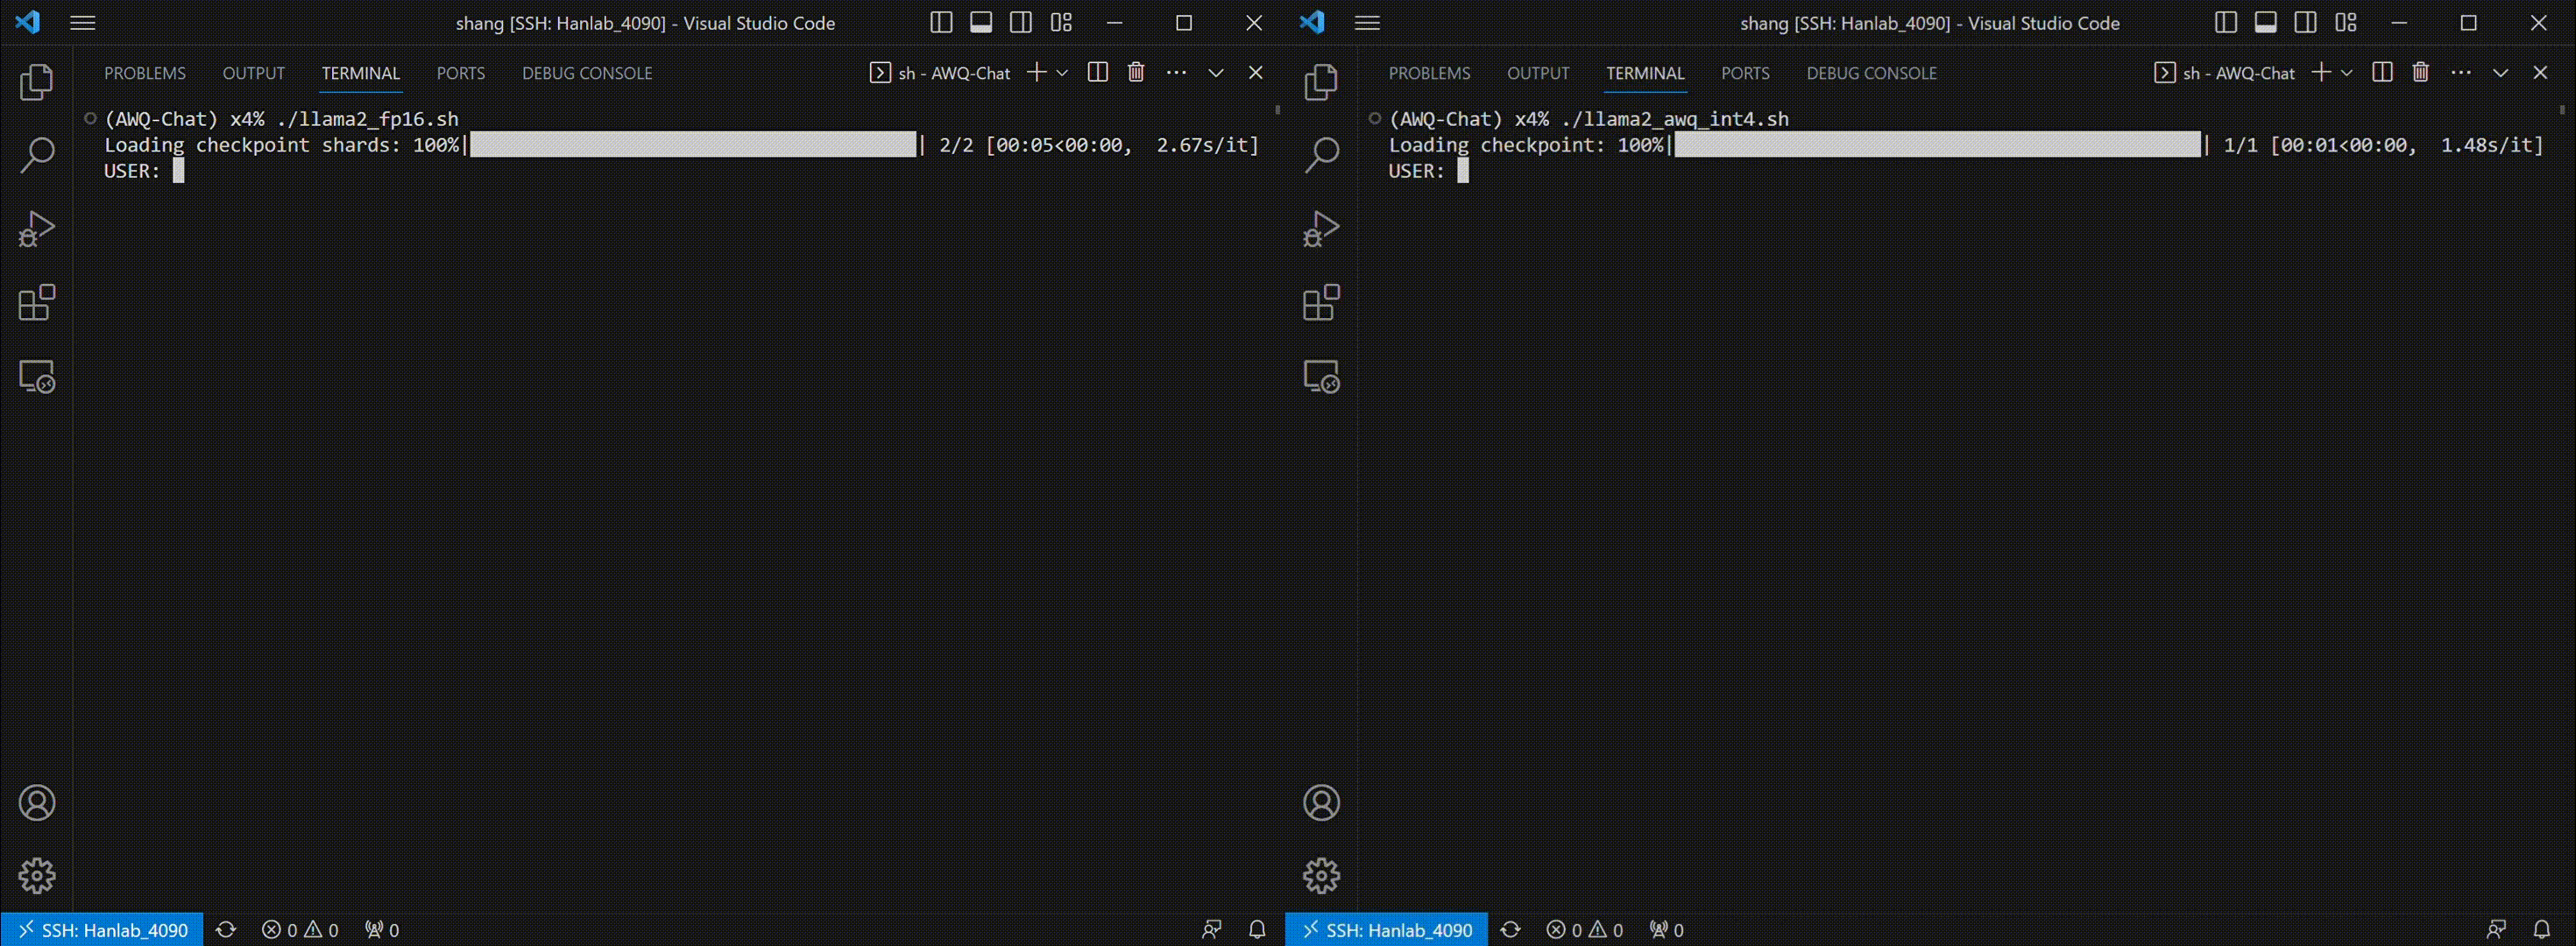

### Demo on an Apple MacBook Air (M1, 2020):


![demo.gif](https://github.com/mit-han-lab/TinyChatEngine/blob/main/assets/figures/chat_demo_m1.gif?raw=true)

# AWQ (activation aware weight only quantization)

Before we begin the below section, it is HIGHLY RECOMMENDED to read the paper by the authors on AWQ. [**here**](https://arxiv.org/pdf/2306.00978)

Or you can refer the slides for the paper [**here**](https://drive.google.com/file/d/1_bI1wxaZhcz_chPxdzelorrBin2sacl1/view?usp=sharing)

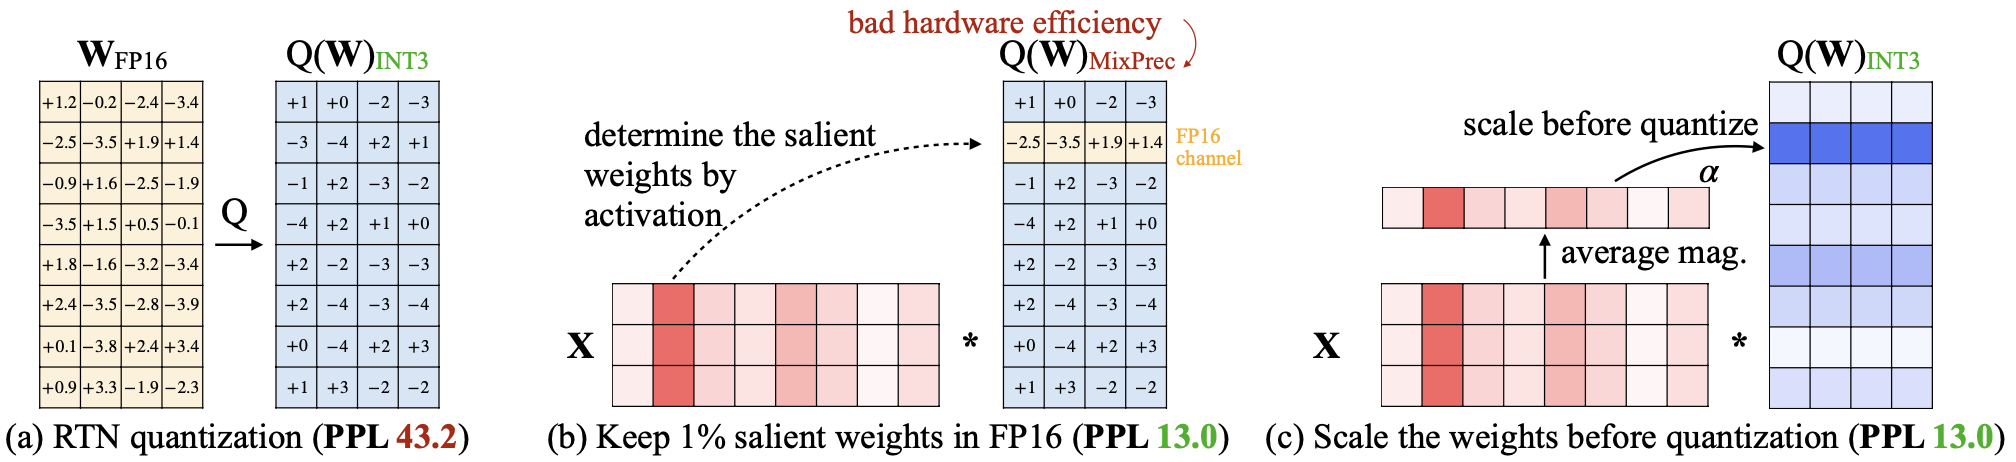

Large language models (LLMs) have shown excellent performance on various tasks, but the astronomical model size raises the hardware barrier for serving (memory size) and slows down token generation (memory bandwidth). LLM sizes and computation are increasing exponentially, while memory bandwidth is increasing slowly. This gap is a major bottleneck for LLMs. In this assignment, we will explore the use of an novel quantization algorithm (AWQ) to reduce memory footprint of LLMs and achieve accelerations for inference.

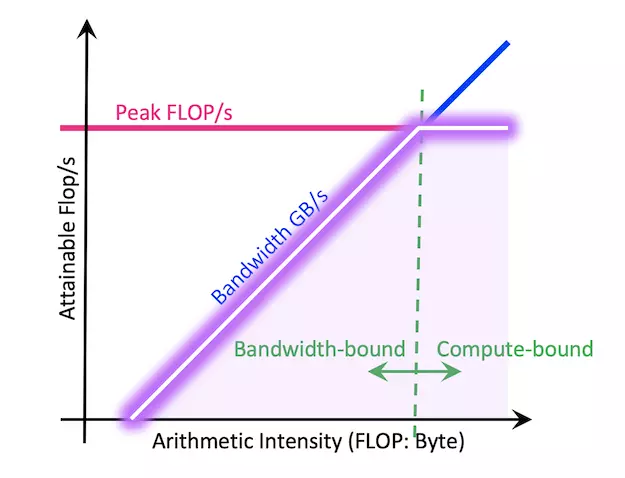

Earlier we have learned the basic methods of quantization.
There are two types of quantization:

- Quantize both weight and activation
    - Better for computation-bounded scenarios: context stage, large batch inference
    - For example, SmoothQuant: W8A8 quantization
- Weight-only quantization
    - Better for memory-bounded scenarios: decoding stage, single batch inference
    - For example, AWQ that will be introduced in this assignment: W4A16 quantization

For the LLaMA-65B model, in the decoding stage of single batch inference, we need to perform GEMV $[1, 8192] \times [8192, 8192]$. Taking the NVIDIA A100 80G as an example, its half-precision (FP16) performance is 312TFLOPS, and the memory bandwidth is about 2000GB/s. Therefore, its computation intensity is:

$$
\frac{\text{FLOP}}{\text{Byte}} = \frac{2\times 8192^2}{8192^2} << \frac{3.12\times 10^{11}}{2\times 10^9}
$$

This is very memory-bounded (~$10^2$ gap), which is why we need low-bit weight quantization.

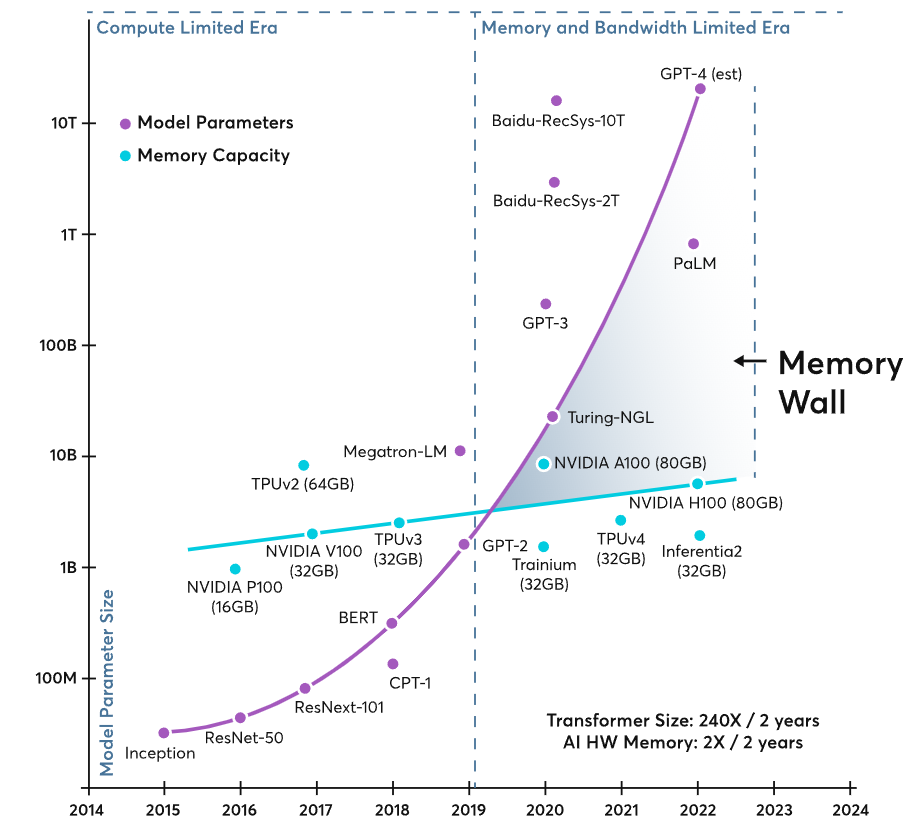

## Setup

In [1]:
print('Installing packages...')
# !pip install torch transformers==4.31.0 accelerate==0.21.0 sentencepiece==0.1.99 tokenizers==0.13.3 datasets==2.15.0 tqdm zstandard
!pip install torch transformers>=4.36 accelerate>=0.23 sentencepiece>=0.1.99 tokenizers>=0.15 datasets>=2.15 tqdm zstandard

Installing packages...


In [ ]:
import tqdm
import torch
from torch import nn
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset
from functools import partial
import gc

Here we use wikitext-2 dataset for evaluation. The dataset is automatically downloaded by the code.

In [3]:
def evaluate(model, tokenizer):
    testenc = load_dataset('wikitext', 'wikitext-2-raw-v1', split='test')
    testenc = tokenizer("\n\n".join(testenc['text']), return_tensors='pt')

    testenc = testenc.input_ids.to(model.device)
    nsamples = 40
    model = model.eval()

    nlls = []
    for i in tqdm.tqdm(range(nsamples), desc="evaluating..."):
        batch = testenc[:, (i * 2048):((i + 1) * 2048)].to(model.device)
        with torch.no_grad():
            lm_logits = model(batch).logits
        shift_logits = lm_logits[:, :-1, :].contiguous().float()
        shift_labels = testenc[:, (i * 2048):((i + 1) * 2048)][:, 1:]
        loss_fct = nn.CrossEntropyLoss()
        loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
        neg_log_likelihood = loss.float() * 2048
        nlls.append(neg_log_likelihood)

    return torch.exp(torch.stack(nlls).sum() / (nsamples * 2048))


The following code is used to calculate the model size.

In [8]:
def get_model_size(model: nn.Module, data_width=16, group_size=-1):

    if group_size != -1:
        data_width += (16 + 4) / group_size

    num_elements = 0
    for param in model.parameters():
        num_elements += param.numel()
    return num_elements * data_width

Byte = 8
KiB = 1024 * Byte
MiB = 1024 * KiB
GiB = 1024 * MiB

Let's first evaluate the perplexity and model size of the FP32 Model.

In [7]:
model_path = "facebook/opt-1.3b"
# model_path = "TinyLlama/TinyLlama_v1.1"
tokenizer = AutoTokenizer.from_pretrained(model_path, use_fast=False)
model = AutoModelForCausalLM.from_pretrained(model_path, device_map="auto")

# Evaluate the model
model_perplexity = evaluate(model, tokenizer)
model_size = get_model_size(model, data_width=32, group_size=128)
print(f"\nmodel perplexity: {model_perplexity:.2f}")
print(f"model size: {model_size/MiB:.2f} MiB")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/685 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/653 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/441 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.63G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

wikitext-2-raw-v1/test-00000-of-00001.pa(…):   0%|          | 0.00/733k [00:00<?, ?B/s]

wikitext-2-raw-v1/train-00000-of-00001.p(…):   0%|          | 0.00/6.36M [00:00<?, ?B/s]

wikitext-2-raw-v1/validation-00000-of-00(…):   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

evaluating...: 100%|██████████| 40/40 [00:59<00:00,  1.48s/it]



model perplexity: 14.47
model size: 5043.73 MiB


Uniform quantization is to map real values in the range $[\beta, \alpha]$ to lie within $[0, 2^{b} - 1]$.

Notation:

- Quantized Weight: $w_q$

- Scale factor: $s_q$

- Zero Point: $z$
\begin{equation}
s_q = \frac{\alpha - \beta}{2^{b} - 1} \tag{1},
\end{equation}
\begin{equation}
z = -\text{Round}(\beta * scale) \tag{2}
\end{equation}
\begin{equation}
w_q = \text{Clamp}(\text{Round}(\frac{w}{s_q}) + z) \tag{3},
\end{equation}



We earlier covered in detail finding this zero point, etc.

### pseudo quantization
The following code is for pseudo quantization.

Pseudo Quantization is used to simulate the effects of quantization on a model  without actually quantizing the model's weights. (i.e. rounding to the nearest quantized value and then **dequantizing back to a float**.)

In [8]:
# core quantization method (simulated quantization)
def pseudo_quantize_tensor(w, n_bit=4, q_group_size=-1):
    org_w_shape = w.shape
    if q_group_size > 0:
        assert org_w_shape[-1] % q_group_size == 0
        w = w.reshape(-1, q_group_size)

    assert w.dim() == 2

    # Calculate the maximum (\alpha) and minimum values (\beta) in the tensor.
    max_val = w.amax(dim=1, keepdim=True)
    assert max_val.dim() == 2 and max_val.size(0) == w.size(0) and max_val.size(1) == 1
    min_val = w.amin(dim=1, keepdim=True)
    assert min_val.dim() == 2 and min_val.size(0) == w.size(0) and min_val.size(1) == 1

    # Calculate the scale factor and zero point.  (Formula 1 & 2)
    max_int = 2 ** n_bit - 1
    scales = (max_val - min_val).clamp(min=1e-5) / max_int
    assert scales.shape == max_val.shape
    zeros = (-torch.round(min_val / scales)).clamp_(0, max_int)
    assert scales.shape == min_val.shape

    assert torch.isnan(scales).sum() == 0
    assert torch.isnan(w).sum() == 0

    # Quantize W: Map values in the range [\beta, \alpha] to lie within [0, 2^b - 1] (Formula 3)
    w = torch.clamp(torch.round(w / scales) + zeros, 0, max_int)
    assert w.dim() == 2 and w.size(0) == scales.size(0) and w.size(1) == q_group_size

    # Dequantize W (pseudo quantization, the inverse transformation of Formula 3)
    w = (w - zeros) * scales
    assert w.dim() == 2 and w.size(0) == scales.size(0) and w.size(1) == q_group_size

    assert torch.isnan(w).sum() == 0

    w = w.reshape(org_w_shape)
    return w

@torch.no_grad()
def pseudo_quantize_model_weight(
    model, w_bit, q_group_size,
):
    for n, m in model.named_modules():
        if isinstance(m, nn.Linear):
            m.weight.data = pseudo_quantize_tensor(m.weight.data, n_bit=w_bit, q_group_size=q_group_size)

Let's evaluate the perplexity and model size of the quantized 3-bit Model.

In [9]:
del model
gc.collect()
torch.cuda.empty_cache()
model = AutoModelForCausalLM.from_pretrained(model_path, device_map="auto")
pseudo_quantize_model_weight(model, w_bit=3, q_group_size=128)

# Evaluate the model
model_perplexity = evaluate(model, tokenizer)
model_size = get_model_size(model, data_width=3, group_size=128)
print(f"\nmodel perplexity: {model_perplexity:.2f}")
print(f"model size: {model_size/MiB:.2f} MiB")

evaluating...: 100%|██████████| 40/40 [01:02<00:00,  1.56s/it]



model perplexity: 121.90
model size: 495.06 MiB


We can see that the model size has decreased, but the perplexity has significantly increased.

### Question 1.1: What if you quantize it to 4-bit, 5-bit or 8-bit? What performence difference do you observe.


In [10]:
# Your Answer:

############### YOUR ANSWER STARTS HERE #################

# Perplexity goes down, model size increases.

############### YOUR ANSWER ENDS HERE #################

In [11]:
del model
gc.collect()
torch.cuda.empty_cache()
model = AutoModelForCausalLM.from_pretrained(model_path, device_map="auto")
pseudo_quantize_model_weight(model, w_bit=4, q_group_size=128)

# Evaluate the model
model_perplexity = evaluate(model, tokenizer)
model_size = get_model_size(model, data_width=4, group_size=128)
print(f"\nmodel perplexity 4-bit: {model_perplexity:.2f}")
print(f"model size 4-bit: {model_size/MiB:.2f} MiB")

evaluating...: 100%|██████████| 40/40 [01:02<00:00,  1.57s/it]



model perplexity 4-bit: 15.22
model size 4-bit: 651.91 MiB


In [12]:
del model
gc.collect()
torch.cuda.empty_cache()
model = AutoModelForCausalLM.from_pretrained(model_path, device_map="auto")
pseudo_quantize_model_weight(model, w_bit=5, q_group_size=128)

# Evaluate the model
model_perplexity = evaluate(model, tokenizer)
model_size = get_model_size(model, data_width=5, group_size=128)
print(f"\nmodel perplexity 5-bit: {model_perplexity:.2f}")
print(f"model size 5-bit: {model_size/MiB:.2f} MiB")

evaluating...: 100%|██████████| 40/40 [01:03<00:00,  1.59s/it]



model perplexity 5-bit: 14.55
model size 5-bit: 808.76 MiB


In [13]:
del model
gc.collect()
torch.cuda.empty_cache()
model = AutoModelForCausalLM.from_pretrained(model_path, device_map="auto")
pseudo_quantize_model_weight(model, w_bit=8, q_group_size=128)

# Evaluate the model
model_perplexity = evaluate(model, tokenizer)
model_size = get_model_size(model, data_width=8, group_size=128)
print(f"\nmodel perplexity 8-bit: {model_perplexity:.2f}")
print(f"model size 8-bit: {model_size/MiB:.2f} MiB")

evaluating...: 100%|██████████| 40/40 [01:03<00:00,  1.60s/it]



model perplexity 8-bit: 14.46
model size 8-bit: 1279.31 MiB


There is a observation in LLM activations that **outliers appear in a small fraction of the channels**. If one channel has an outlier, it **persistently appears in all tokens**. The variance amongst the channels for a given token is large (the activations in some channels are very large, but most are small), but the variance between the magnitudes of a given channel across tokens is small (outlier channels are consistently large).

According to the observation of AWQ, weight channels corresponding to activation outliers are more salient, and preserving those salient weights can lead to a significant performance improvement. Next, let's try to find the salient weights and retain them as original values to observe the change in perplexity.

The following code is used to load the calibration dataset, so as to obtain activation outliers to identify salient weights.

### Question 1.2: What is a calibration dataset, why do we need it?
Answer in 2 sentences at maximum, google search and answer.



In [14]:
# Your Answer:

############### YOUR ANSWER STARTS HERE #################

# It's a small representative subset of data used to measure activation statistics.

############### YOUR ANSWER ENDS HERE #################

In [15]:
def get_calib_dataset(tokenizer=None, n_samples=256, block_size=512):
    dataset = load_dataset("mit-han-lab/pile-val-backup", split="validation")
    dataset = dataset.shuffle(seed=42)
    samples = []
    n_run = 0
    for data in dataset:
        line = data["text"]
        line = line.strip()
        line_encoded = tokenizer.encode(line)
        if len(line_encoded) > block_size:
            continue
        sample = torch.tensor([line_encoded])
        if sample.numel() == 0:
            continue
        samples.append(sample)
        n_run += 1
        if n_run == n_samples:
            break

    # now concatenate all samples and split according to block size
    cat_samples = torch.cat(samples, dim=1)
    n_split = cat_samples.shape[1] // block_size
    print(f" * Split into {n_split} blocks")
    return [cat_samples[:, i*block_size:(i+1)*block_size] for i in range(n_split)]

@torch.no_grad()
def get_calib_feat(model, tokenizer):
    input_dict = dict()
    def stat_input_max_hook(m, x, y, name):
        if isinstance(x, tuple):
            x = x[0]
        x_max = x.view(-1, x.shape[-1]).abs().mean(dim=0).cpu().detach()
        if name not in input_dict:
            input_dict[name] = [x_max]
        else:
            input_dict[name] += [x_max]

    hooks = []
    for name, m in model.named_modules():
        if isinstance(m, nn.Linear):
            hooks.append(
                m.register_forward_hook(
                    partial(stat_input_max_hook, name=name)))

    print("Collecting activation scales...")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    samples = get_calib_dataset(tokenizer)
    pbar = tqdm.tqdm(samples)
    for input_ids in pbar:
        input_ids = input_ids.to(device)
        model(input_ids)

    for hook in hooks:
        hook.remove()
    return input_dict

In [16]:
del model
gc.collect()
torch.cuda.empty_cache()
model = AutoModelForCausalLM.from_pretrained(model_path, device_map="auto")
input_feat = get_calib_feat(model, tokenizer)

README.md:   0%|          | 0.00/167 [00:00<?, ?B/s]

Repo card metadata block was not found. Setting CardData to empty.


val.jsonl.zst:   0%|          | 0.00/471M [00:00<?, ?B/s]

Generating validation split:   0%|          | 0/214670 [00:00<?, ? examples/s]

 * Split into 127 blocks


100%|██████████| 127/127 [00:52<00:00,  2.42it/s]


### Question 1.3: What is perplexity?

 explain here referencing above perplexity caluclation function



In [17]:
# Your Answer:

############### YOUR ANSWER STARTS HERE #################

# Measure of how well a model predicts a sequence of tokens.
# Intuitely, it's how surprised the model is on seeing the next token, lower means more confident, higher means more uncertain.
# Formally, it's exp((sum_NLL)/N) where sum_NLL is the sum of negative log-likelihoods over all N tokens.

############### YOUR ANSWER ENDS HERE #################

### Question 2
#### Question 2.1
Next, please add codes before and after the quantization to protect 1% of the salient weight channels (1% channels with highest importance), ensuring that their values remain unchanged after quantization.

(**Your output perplexity will be ~ 17.15**)

In [18]:
@torch.no_grad()
def pseudo_quantize_model_salient_weight_fp16(
    model, w_bit, q_group_size, input_feat
):
    for n, m in model.named_modules():
        if isinstance(m, nn.Linear):
            importance = sum(input_feat[n]).float()

            ############### YOUR CODE STARTS HERE ###############

            # Step 1: Find 1% of the salient weight channels according to importance (hint: use torch.topk())
            _, outlier_indices = torch.topk(importance, int(0.01*importance.numel()))
            assert outlier_indices.dim() == 1

            ############### YOUR CODE ENDS HERE #################

            # Back up the values of the salient weight channels
            outlier = m.weight.data[:, outlier_indices].clone()

            m.weight.data = pseudo_quantize_tensor(m.weight.data, n_bit=w_bit, q_group_size=q_group_size)

            ############### YOUR CODE STARTS HERE ###############

            # Step 2: Restore the 1% salient weight channels to their original FP16 values
            m.weight.data[:, outlier_indices] = outlier

            ############### YOUR CODE ENDS HERE #################

In [19]:
del model
gc.collect()
torch.cuda.empty_cache()
model = AutoModelForCausalLM.from_pretrained(model_path, device_map="auto")
pseudo_quantize_model_salient_weight_fp16(model, w_bit=3, q_group_size=128, input_feat=input_feat)

# Evaluate the model
model_perplexity = evaluate(model, tokenizer)
model_size = get_model_size(model, data_width=3, group_size=128)
print(f"\nmodel perplexity: {model_perplexity:.2f}")
print(f"model size: {model_size/MiB:.2f} MiB")

evaluating...: 100%|██████████| 40/40 [01:02<00:00,  1.56s/it]



model perplexity: 17.15
model size: 495.06 MiB


#### Question 2.2
Let's conduct an ablation experiment: randomly protect 1% of the weight channels, ensuring that their values remain unchanged after quantization, and then observe the perplexity. (**The desired perplexity is over 100**)




In [20]:
@torch.no_grad()
def pseudo_quantize_model_random_weight_fp16(
    model, w_bit, q_group_size, input_feat
):
    for n, m in model.named_modules():
        if isinstance(m, nn.Linear):
            importance = sum(input_feat[n]).float()

            ############### YOUR CODE STARTS HERE ###############

            # Step 1: Randomly choose 1% of the weight channels
            outlier_mask = torch.randperm(importance.numel())[:int(0.01*importance.numel())]
            # print("outlier_mask: ", outlier_mask.shape)
            assert outlier_mask.dim() == 1

            ############### YOUR CODE ENDS HERE #################

            # Back up the values of the selected weight channels
            outlier = m.weight.data[:, outlier_mask].clone()

            m.weight.data = pseudo_quantize_tensor(m.weight.data, n_bit=w_bit, q_group_size=q_group_size)

            ############### YOUR CODE STARTS HERE ###############

            # Step 2: Restore the 1% selected weight channels to their original FP16 values
            m.weight.data[:, outlier_mask] = outlier

            ############### YOUR CODE ENDS HERE #################

In [21]:
del model
gc.collect()
torch.cuda.empty_cache()
model = AutoModelForCausalLM.from_pretrained(model_path, device_map="auto")
pseudo_quantize_model_random_weight_fp16(model, w_bit=3, q_group_size=128, input_feat=input_feat)

# Evaluate the model
model_perplexity = evaluate(model, tokenizer)
model_size = get_model_size(model, data_width=3, group_size=128)
print(f"\nmodel perplexity: {model_perplexity:.2f}")
print(f"model size: {model_size/MiB:.2f} MiB")

evaluating...: 100%|██████████| 40/40 [01:01<00:00,  1.55s/it]



model perplexity: 121.19
model size: 495.06 MiB


#### Question 2.3
Please provide a possible explanation for why the salient weight channels are so important.



In [22]:
# Your Answser:
############### YOUR ANSWER STARTS HERE #################

# The network relies heavily on these high activation (salient) channels. Protecting these channels preserves the integrity of the learned knowledge.

############### YOUR ANSWER ENDS HERE #################

### Question 3

Despite keeping 0.1% of weights in FP16 can improve the quantized performance
without a noticeable increase in model size (measured in total bits), such a mixed-precision data type will make the system implementation difficult. We need to come up with a method to protect the important weights without actually keeping them as FP16.

According to the methodology of AWQ, simply scaling up the salient weight channels can protect them. The principle is as follows:

- Consider a linear layer channel $\mathbf{y} = \mathbf{w}x$ (from $\mathbf{W}x$). We care about the quantization error from $Q(\mathbf{w})x$.

- $Err(Q(\mathbf{w}) x) = Δ\cdot RoundErr(\frac{\mathbf{w}}{Δ})\cdot x$, $Δ = \frac{\max(|w|)}{2^{N - 1}}$.
- The scaled version is $Err(Q(\mathbf{w} \cdot s)(\frac{x}{s})) = Δ\cdot RoundErr(\frac{\mathbf{w}}{Δ})\cdot x\cdot \mathbf{\frac{1}{s}}$.
- The $RoundErr$ is always ~0.25 (average from 0-0.5).
- When the group size is relatively large (e.g., 128), scaling up one channel usually does not increase the maximum value in a group (i.e. $Δ$ remains unchanged).
- Thus, $Err(Q(\mathbf{w} \cdot s)(\frac{x}{s})) = Δ\cdot RoundErr(\frac{\mathbf{w}}{Δ})\cdot x\cdot \mathbf{\frac{1}{s}}$ < $Δ\cdot RoundErr(\frac{\mathbf{w}}{Δ})\cdot x = Err(Q(\mathbf{w}) x)$.

Taking the following figure as an example, if we assume 3-bit int quantization, then the quantization error caused by the value in the last column of the second row of $W(+1.4)$ should be $Err(Q(\mathbf{w}) x) = Δ\cdot RoundErr(\frac{\mathbf{w}}{Δ})\cdot x$ = $\frac{4}{2^{3 - 1}} * |1.4 - 1.0| * (2 + 2 + 2) = 2.4$.

If the second channel is scaled up by a factor of $2$, the resulting quantization error would reduce to $\frac{4}{2^{3 - 1}} * |2.8 - 3.0| * (2/2 + 2/2 + 2/2) = 0.6$.

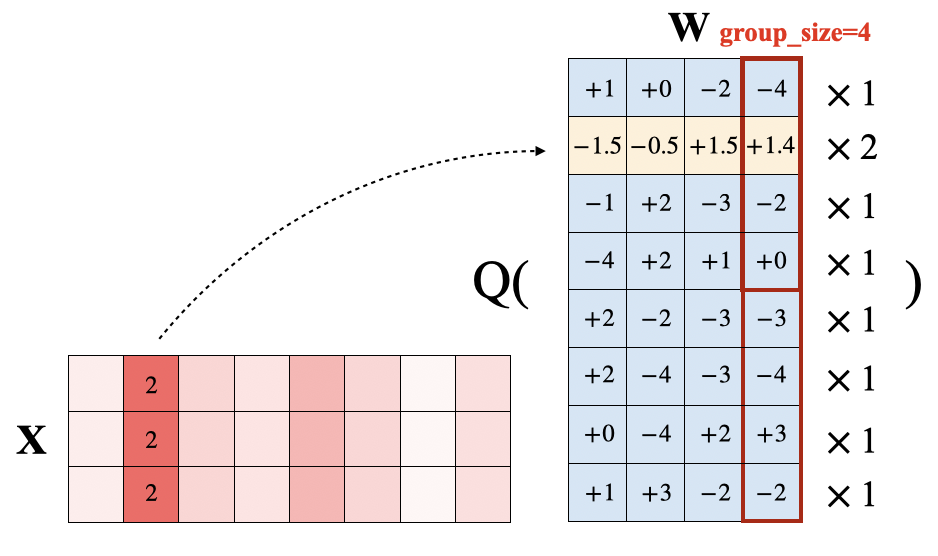

#### Question 3.1
Please write code to scale up the salient weight channels, then quantize it, and finally scale it back down, and observe the changes in perplexity.
(**The desired perplexity is 18.93**)

In [23]:
@torch.no_grad()
def pseudo_quantize_model_weight_scaleup(
    model, w_bit, q_group_size, input_feat, scale_factor
):
    for n, m in model.named_modules():
        if isinstance(m, nn.Linear):
            importance = sum(input_feat[n]).float()

            ############### YOUR CODE STARTS HERE ###############

            # Step 1: Find 1% of the salient weight channels
            _, outlier_mask = torch.topk(importance, int(0.01*importance.numel()))
            assert outlier_mask.dim() == 1

            ############### YOUR CODE ENDS HERE #################

            # To simulate applying the scale factor, we can simply multiply it before quantization, and then divide by the scale factor after quantization.
            # Scale up the values of the salient weight channels
            m.weight.data[:, outlier_mask] *= scale_factor

            m.weight.data = pseudo_quantize_tensor(m.weight.data, n_bit=w_bit, q_group_size=q_group_size)

            ############### YOUR CODE STARTS HERE ###############

            # Step 2: Scale back down the values of the salient weight channels

            m.weight.data[:, outlier_mask] /= scale_factor

            ############### YOUR CODE ENDS HERE #################

In [24]:
del model
gc.collect()
torch.cuda.empty_cache()
model = AutoModelForCausalLM.from_pretrained(model_path, device_map="auto")
pseudo_quantize_model_weight_scaleup(model, w_bit=3, q_group_size=128, input_feat=input_feat, scale_factor=2)

# Evaluate the model
model_perplexity = evaluate(model, tokenizer)
model_size = get_model_size(model, data_width=3, group_size=128)
print(f"\nmodel perplexity: {model_perplexity:.2f}")
print(f"model size: {model_size/MiB:.2f} MiB")

evaluating...: 100%|██████████| 40/40 [01:02<00:00,  1.55s/it]



model perplexity: 18.93
model size: 495.06 MiB


#### Question 3.2
Please try different scale factors (e.g. 1, 2, 3, and 4) in the code and observe the changes in perplexity.

Did you observe the perplexity first decreasing and then increasing? Please explain why this would happen based on the principle mentioned above.



In [25]:
# Q3.2

scale_factors = [1, 2, 3, 4, 5, 6, 7, 8]
perplexities = []
model_sizes = []

for sf in scale_factors:
    del model
    gc.collect()
    torch.cuda.empty_cache()

    model = AutoModelForCausalLM.from_pretrained(model_path, device_map="auto")
    pseudo_quantize_model_weight_scaleup(model, w_bit=3, q_group_size=128, input_feat=input_feat, scale_factor=sf)

    model_perplexity = evaluate(model, tokenizer)
    model_perplexity = model_perplexity.detach().cpu().item()
    model_size = get_model_size(model, data_width=3, group_size=128)

    perplexities.append(model_perplexity)
    model_sizes.append(model_size/MiB)

    print(f"scale factor: {sf}, perplexity: {model_perplexity:.2f}, size: {model_sizes[-1]:.2f} MiB")

results = {
    "scale_factors": scale_factors,
    "perplexities": perplexities,
    "model_sizes": model_sizes
}

evaluating...: 100%|██████████| 40/40 [01:02<00:00,  1.55s/it]


scale factor: 1, perplexity: 121.90, size: 495.06 MiB


evaluating...: 100%|██████████| 40/40 [01:02<00:00,  1.55s/it]


scale factor: 2, perplexity: 18.93, size: 495.06 MiB


evaluating...: 100%|██████████| 40/40 [01:02<00:00,  1.55s/it]


scale factor: 3, perplexity: 19.25, size: 495.06 MiB


evaluating...: 100%|██████████| 40/40 [01:02<00:00,  1.55s/it]


scale factor: 4, perplexity: 21.26, size: 495.06 MiB


evaluating...: 100%|██████████| 40/40 [01:02<00:00,  1.55s/it]


scale factor: 5, perplexity: 24.50, size: 495.06 MiB


evaluating...: 100%|██████████| 40/40 [01:01<00:00,  1.55s/it]


scale factor: 6, perplexity: 30.36, size: 495.06 MiB


evaluating...: 100%|██████████| 40/40 [01:01<00:00,  1.55s/it]


scale factor: 7, perplexity: 47.13, size: 495.06 MiB


evaluating...: 100%|██████████| 40/40 [01:01<00:00,  1.54s/it]


scale factor: 8, perplexity: 100.99, size: 495.06 MiB


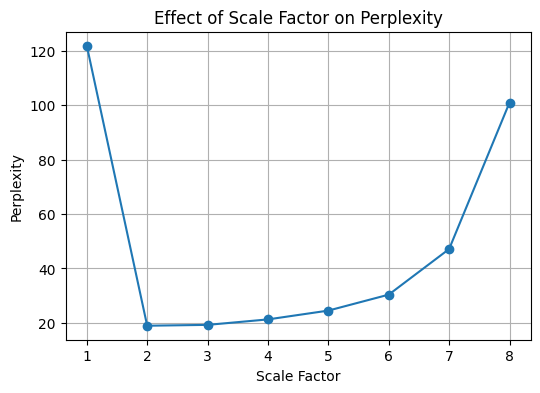

In [26]:
import matplotlib.pyplot as plt

scale_factors = results["scale_factors"]
perplexities = results["perplexities"]

plt.figure(figsize=(6, 4))
plt.plot(scale_factors, perplexities, marker='o')
plt.title("Effect of Scale Factor on Perplexity")
plt.xlabel("Scale Factor")
plt.ylabel("Perplexity")
plt.grid(True)
plt.show()

In [27]:
# Your Answer:
############### YOUR ANSWER STARTS HERE #################

# I'm not too sure about this, but maybe, moderate scaling ([1,2] here) helps weights better distribute across the quantization range.
# For larger scale factors (>2 here), the weights saturate, increasing quantization error and thus perplexity.

############### YOUR ANSWER ENDS HERE #################

### Question 3.3

Due to the instability of fine-tuning, it would be a better choice to find the optimal $s$ within a predefined search space. We can find the optimal scale in the search space to protect the salient weights while also considering other values. In practice, it can be observed that considering just the activations is sufficient to yield good results. Please add the code for search and run it to observe the perplexity. (**The desired perplexity is 17.92**)

$$
𝐋(\mathbf{s})=\lVert Q(\mathbf{W}\cdot \mathbf{s})  (\mathbf{s^{-1}} \cdot \mathbf{X}) - \mathbf{W}\mathbf{X}  \rVert,  \quad\mathbf{s}= \mathbf{s_X}^{\alpha}
$$
$$
\mathbf{s}^* = \text{argmin}_{\mathbf{s}} 𝐋(\mathbf{s}),\quad \alpha^*=\text{argmin}_{\alpha} 𝐋(\mathbf{s_X}^{\alpha})
$$

In [35]:
@torch.no_grad()
def scale_ln_fcs(ln, fcs, scales):
    if not isinstance(fcs, list):
        fcs = [fcs]

    scales = scales.to(ln.weight.device)

    ln.weight.div_(scales)
    if hasattr(ln, 'bias') and ln.bias is not None:
        ln.bias.div_(scales)

    for fc in fcs:
        fc.weight.mul_(scales.view(1, -1))

    for p in ln.parameters():
        assert torch.isnan(p).sum() == 0
    for fc in fcs:
        for p in fc.parameters():
            assert torch.isnan(p).sum() == 0


@torch.no_grad()
def scale_fc_fc(fc1, fc2, scales):
    assert isinstance(fc1, nn.Linear)
    assert isinstance(fc2, nn.Linear)

    scales = scales.to(fc1.weight.device)

    # fc1.weight.div_(scales.view(-1, 1))
    fc1.weight[-scales.size(0):].div_(scales.view(-1, 1))
    if fc1.bias is not None:
        fc1.bias.div_(scales.view(-1))

    fc2.weight.mul_(scales.view(1, -1))

    for p in fc1.parameters():
        assert torch.isnan(p).sum() == 0
    for p in fc2.parameters():
        assert torch.isnan(p).sum() == 0

@torch.no_grad()
def auto_scale_block(module, name, w_bit,
                     q_group_size,
                     input_feat):

    # find the best scale ratio
    def _search_module_scale(block, linears2scale: list, x, kwargs={}):

        x = x.to(next(block.parameters()).device)
        with torch.no_grad():
            org_out = block(x, **kwargs)
            if isinstance(org_out, tuple):
                org_out = org_out[0]

        s_x = x.view(-1, x.shape[-1]).abs().mean(0)

        ############### YOUR CODE STARTS HERE ###############

        # Step 1: Initialize the best_error, best_ratio and best_scales
        best_error = float('inf')
        best_ratio = -1
        best_scales = None

        ############### YOUR CODE ENDS HERE #################

        n_grid = 20
        history = []

        org_sd = {k: v.cpu() for k, v in block.state_dict().items()}
        for ratio in range(n_grid):
            # ratio is the \alpha in the formula
            ratio = ratio * 1 / n_grid

            ############### YOUR CODE STARTS HERE ###############

            # Step 2: Calculate the scales by the formula: scales = s_x^ratio
            # scales = s_x**ratio !! this gives nans !!
            scales = torch.clamp(s_x, 1e-5) ** ratio

            assert scales.shape == s_x.shape

            ############### YOUR CODE ENDS HERE #################

            scales = scales / (scales.max() * scales.min()).sqrt().view(1, -1)

            for fc in linears2scale:

                scales = scales.to(fc.weight.device)

                # Scale up the values of the weight channels
                fc.weight.mul_(scales)

                fc.weight.data = pseudo_quantize_tensor(fc.weight.data, w_bit, q_group_size)

                ############### YOUR CODE STARTS HERE ###############

                # Step 3: Scale back down the values of the weight channels
                fc.weight.data /= scales

                ############### YOUR CODE ENDS HERE #################

            out = block(x, **kwargs)
            if isinstance(out, tuple):
                out = out[0]

            loss = (org_out - out).float().pow(2).mean().item()  # float prevents overflow
            history.append(loss)
            is_best = loss < best_error
            if is_best:
                best_error = loss
                best_ratio = ratio
                best_scales = scales
            block.load_state_dict(org_sd)

        if best_ratio == -1:
            print(history)
            raise Exception

        best_scales = best_scales.view(-1)

        assert torch.isnan(best_scales).sum() == 0, best_scales
        return best_scales.detach()

    # attention input
    inp = input_feat[name + '.self_attn.out_proj']
    inp = torch.cat([x.unsqueeze(0) for x in inp], dim=0).unsqueeze(0)
    qkv = [module.self_attn.q_proj, module.self_attn.k_proj, module.self_attn.v_proj]
    final_scales = _search_module_scale(module.self_attn, qkv, inp)
    scale_ln_fcs(module.self_attn_layer_norm, qkv, final_scales)

    # attn out
    inp = input_feat[name + '.self_attn.out_proj']
    inp = torch.cat([x.unsqueeze(0) for x in inp], dim=0)
    final_scales = _search_module_scale(module.self_attn.out_proj, [module.self_attn.out_proj], inp)
    scale_fc_fc(module.self_attn.v_proj, module.self_attn.out_proj, final_scales)

    # fc1
    inp = input_feat[name + '.fc1']
    inp = torch.cat([x.unsqueeze(0) for x in inp], dim=0)
    final_scales = _search_module_scale(module.fc1, [module.fc1], inp)
    scale_ln_fcs(module.final_layer_norm, module.fc1, final_scales)

    # fc2
    inp = input_feat[name + '.fc2']
    inp = torch.cat([x.unsqueeze(0) for x in inp], dim=0)
    final_scales = _search_module_scale(module.fc2, [module.fc2], inp)
    scale_fc_fc(module.fc1, module.fc2, final_scales)

@torch.no_grad()
def pseudo_quantize_model_weight_auto_scale(
    model, w_bit, q_group_size, input_feat
):
    from transformers.models.opt.modeling_opt import OPTDecoderLayer

    for name, module in model.named_modules():
        if isinstance(module, OPTDecoderLayer):
            auto_scale_block(module, name, w_bit, q_group_size, input_feat)

    for n, m in model.named_modules():
        if isinstance(m, nn.Linear):
            m.weight.data = pseudo_quantize_tensor(m.weight.data, n_bit=w_bit, q_group_size=q_group_size)

In [36]:
del model
gc.collect()
torch.cuda.empty_cache()
model = AutoModelForCausalLM.from_pretrained(model_path, device_map="auto")
pseudo_quantize_model_weight_auto_scale(model, w_bit=3, q_group_size=128, input_feat=input_feat)

# Evaluate the model
model_perplexity = evaluate(model, tokenizer)
model_size = get_model_size(model, data_width=3, group_size=128)
print(f"\nmodel perplexity: {model_perplexity:.2f}")
print(f"model size: {model_size/MiB:.2f} MiB")

evaluating...: 100%|██████████| 40/40 [01:02<00:00,  1.56s/it]



model perplexity: 17.93
model size: 495.06 MiB


### Question 4
Can you think of any optimization techniques without mixed precision? Think of any random idea you may have by which we can improve either the perplexity score or reduce the model size.

It can be any intuitive idea you may have, answer with atleast 2 paragraphs explaining your approach (no GPT please)





In [27]:
# Your Answer:
############### YOUR ANSWER STARTS HERE #################

# Borrowing and modifying from https://efficientml.ai Lab1
# Fine-grained Pruning

############### YOUR ANSWER ENDS HERE #################


## Bonus Task

Implement the technique you though of earlier here and show emperical results.




In conclusion, we can significantly reduce perplexity without using mixed-precision. Through an efficient kernel implementation, the 4-bit model can achieve decent acceleration for inference. Writing the actual efficient kernel is ~un~fortunately out of the scope of this assignment!



In [1]:
import tqdm
import torch
from torch import nn
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset
from functools import partial
import gc
import math
import matplotlib.pyplot as plt

In [2]:
def evaluate(model, tokenizer):
    testenc = load_dataset('wikitext', 'wikitext-2-raw-v1', split='test')
    testenc = tokenizer("\n\n".join(testenc['text']), return_tensors='pt')

    testenc = testenc.input_ids.to(model.device)
    nsamples = 40
    model = model.eval()

    nlls = []
    for i in tqdm.tqdm(range(nsamples), desc="evaluating..."):
        batch = testenc[:, (i * 1024):((i + 1) * 1024)].to(model.device)
        with torch.no_grad():
            lm_logits = model(batch).logits
        shift_logits = lm_logits[:, :-1, :].contiguous().float()
        shift_labels = testenc[:, (i * 1024):((i + 1) * 1024)][:, 1:]
        loss_fct = nn.CrossEntropyLoss()
        loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
        neg_log_likelihood = loss.float() * 1024
        nlls.append(neg_log_likelihood)

    return torch.exp(torch.stack(nlls).sum() / (nsamples * 1024))

In [3]:
def evaluate_accuracy(model, tokenizer):
    testenc = load_dataset('wikitext', 'wikitext-2-raw-v1', split='test')
    testenc = tokenizer("\n\n".join(testenc['text']), return_tensors='pt')

    input_ids = testenc.input_ids.to(model.device)
    nsamples = 40
    model.eval()

    total_tokens = 0
    correct_tokens = 0

    for i in tqdm.tqdm(range(nsamples), desc="evaluating accuracy..."):
        batch = input_ids[:, (i * 1024):((i + 1) * 1024)].to(model.device)
        with torch.no_grad():
            outputs = model(batch)
            logits = outputs.logits
            preds = torch.argmax(logits[:, :-1, :], dim=-1)
            labels = batch[:, 1:]  # shift labels

        mask = labels != tokenizer.pad_token_id if tokenizer.pad_token_id is not None else torch.ones_like(labels, dtype=torch.bool)
        correct_tokens += (preds[mask] == labels[mask]).sum().item()
        total_tokens += mask.sum().item()

    accuracy = correct_tokens / total_tokens
    return accuracy

In [4]:
def get_num_parameters(model: nn.Module, count_nonzero_only=False) -> int:
    """
    calculate the total number of parameters of model
    :param count_nonzero_only: only count nonzero weights
    """
    num_counted_elements = 0
    for param in model.parameters():
        if count_nonzero_only:
            num_counted_elements += param.count_nonzero()
        else:
            num_counted_elements += param.numel()
    return num_counted_elements


def get_model_size(model: nn.Module, data_width=32, count_nonzero_only=False) -> int:
    """
    calculate the model size in bits
    :param data_width: #bits per element
    :param count_nonzero_only: only count nonzero weights
    """
    return get_num_parameters(model, count_nonzero_only) * data_width

Byte = 8
KiB = 1024 * Byte
MiB = 1024 * KiB
GiB = 1024 * MiB

In [5]:
# model_path = "facebook/opt-1.3b"
model_path = "distilbert/distilgpt2"
tokenizer = AutoTokenizer.from_pretrained(model_path, use_fast=False)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

In [18]:
# del model
gc.collect()
torch.cuda.empty_cache()
model = AutoModelForCausalLM.from_pretrained(model_path, device_map="auto")

model_perplexity = evaluate(model, tokenizer)
model_accuracy = evaluate_accuracy(model, tokenizer)
model_size = get_model_size(model)
print(f"\nmodel perplexity: {model_perplexity:.2f}")
print(f"model accuracy: {model_accuracy}")
print(f"model size: {model_size/MiB:.2f} MiB")

evaluating accuracy...: 100%|██████████| 40/40 [00:02<00:00, 16.93it/s]


model perplexity: 47.38
model accuracy: 0.32817693059628544
model size: 312.47 MiB


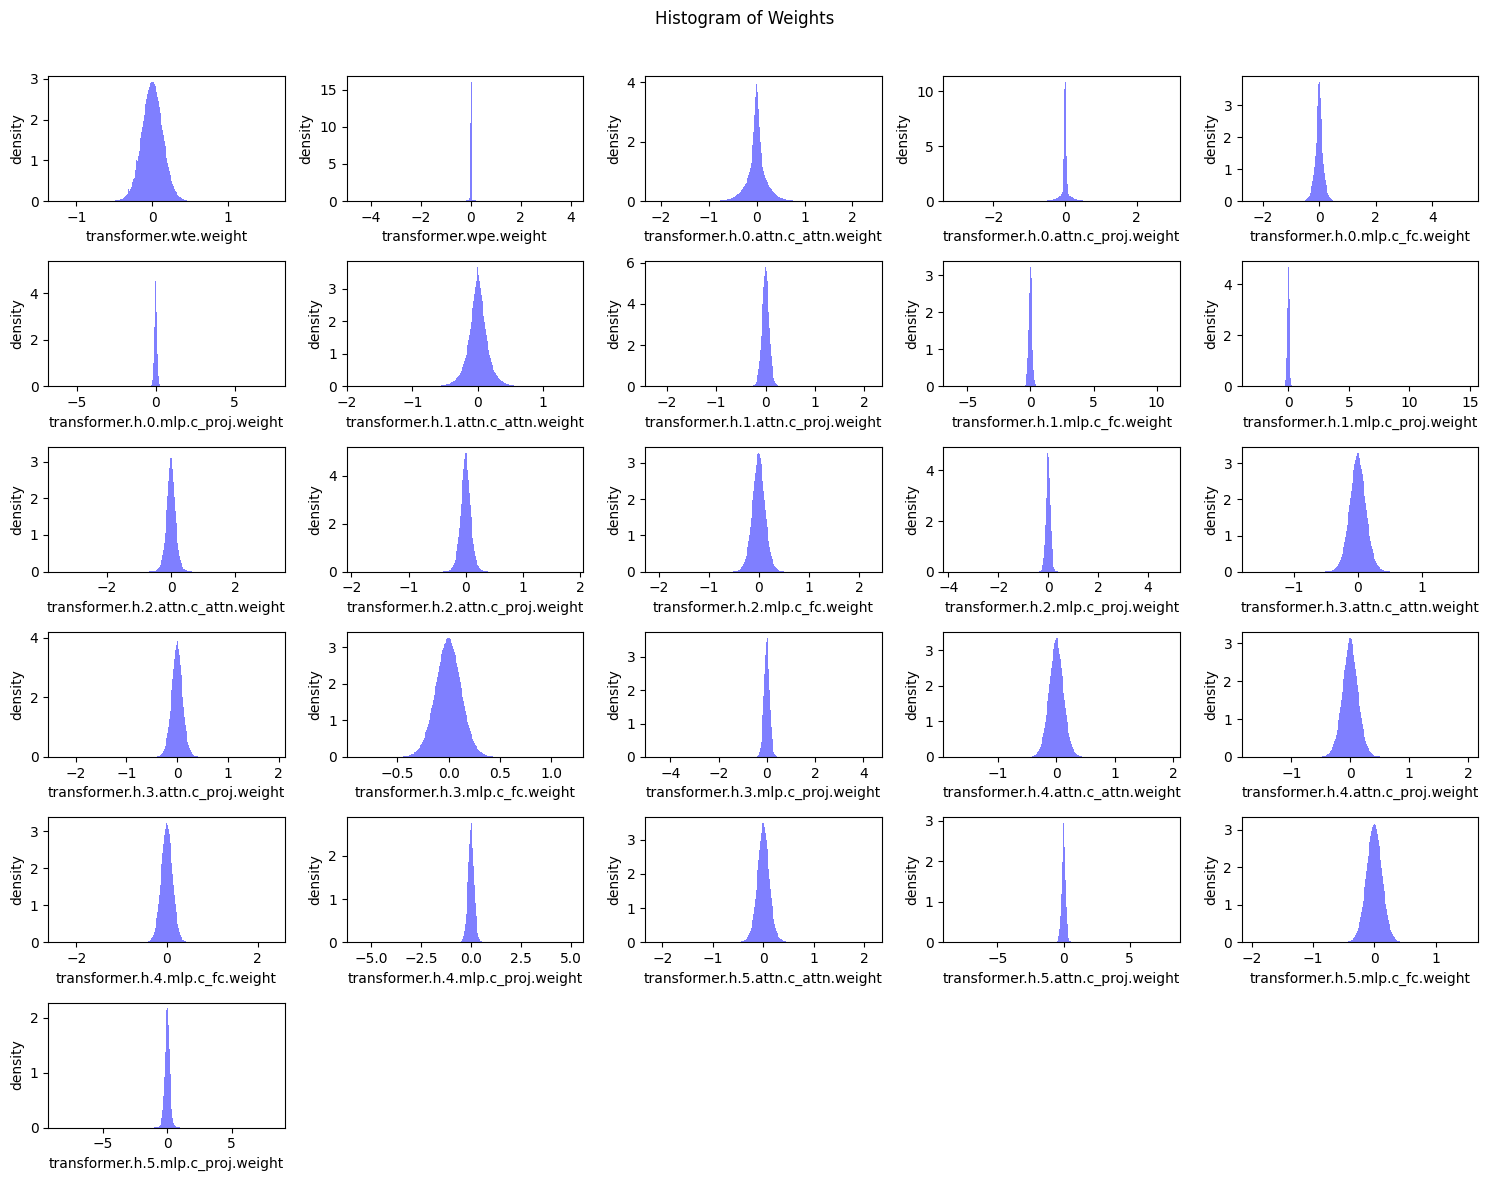

In [9]:
def plot_weight_distribution(model, bins=256, count_nonzero_only=False):

    weight_params = [(name, p) for name, p in model.named_parameters() if p.dim() > 1]
    n = len(weight_params)
    # print(n)
    rows = math.ceil(math.sqrt(n))
    cols = math.ceil(n / rows)
    # print(rows, cols)

    fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*2))
    axes = axes.ravel()

    for i, (name, param) in enumerate(weight_params):
        ax = axes[i]
        param_data = param.detach().view(-1).cpu()
        if count_nonzero_only:
            param_data = param_data[param_data != 0]
        ax.hist(param_data, bins=bins, density=True, color='blue', alpha=0.5)
        ax.set_xlabel(name)
        ax.set_ylabel('density')

    for j in range(i+1, len(axes)):
        axes[j].axis('off')

    fig.suptitle('Histogram of Weights')
    fig.tight_layout()
    fig.subplots_adjust(top=0.925)
    plt.show()


plot_weight_distribution(model)

In [10]:
def fine_grained_prune(tensor: torch.Tensor, sparsity : float) -> torch.Tensor:
    """
    magnitude-based pruning for single tensor
    :param tensor: torch.(cuda.)Tensor, weight of conv/fc layer
    :param sparsity: float, pruning sparsity
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    :return:
        torch.(cuda.)Tensor, mask for zeros
    """
    sparsity = min(max(0.0, sparsity), 1.0)
    if sparsity == 1.0:
        tensor.zero_()
        return torch.zeros_like(tensor)
    elif sparsity == 0.0:
        return torch.ones_like(tensor)

    num_elements = tensor.numel()

    ##################### YOUR CODE STARTS HERE #####################
    # Step 1: calculate the #zeros (please use round())
    num_zeros = round(num_elements * sparsity)
    # Step 2: calculate the importance of weight
    importance = torch.abs(tensor)
    # Step 3: calculate the pruning threshold
    threshold = torch.kthvalue(importance.flatten(), num_zeros)[0]
    # Step 4: get binary mask (1 for nonzeros, 0 for zeros)
    mask = importance > threshold
    ##################### YOUR CODE ENDS HERE #######################

    # Step 5: apply mask to prune the tensor
    tensor.mul_(mask)

    return mask

In [11]:
class FineGrainedPruner:
    def __init__(self, model, sparsity_dict):
        self.masks = FineGrainedPruner.prune(model, sparsity_dict)

    @torch.no_grad()
    def apply(self, model):
        for name, param in model.named_parameters():
            if name in self.masks:
                param *= self.masks[name]

    @staticmethod
    @torch.no_grad()
    def prune(model, sparsity_dict):
        masks = dict()
        for name, param in model.named_parameters():
            if param.dim() > 1: # we only prune conv and fc weights
                masks[name] = fine_grained_prune(param, sparsity_dict[name])
        return masks

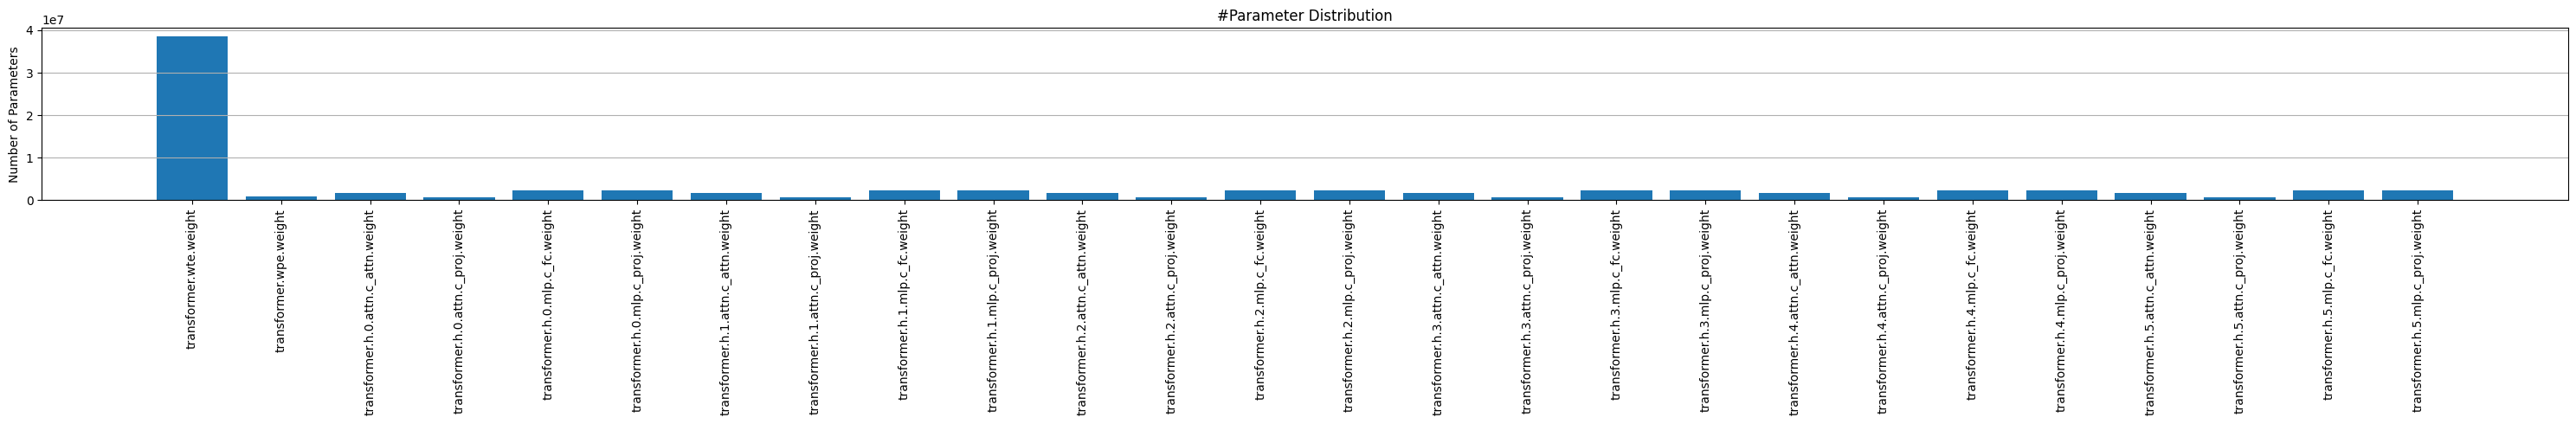

In [12]:
def plot_num_parameters_distribution(model):
    num_parameters = dict()
    for name, param in model.named_parameters():
        if param.dim() > 1:
            num_parameters[name] = param.numel()
    fig = plt.figure(figsize=(30, 5))
    plt.grid(axis='y')
    plt.bar(list(num_parameters.keys()), list(num_parameters.values()))
    plt.title('#Parameter Distribution')
    plt.ylabel('Number of Parameters')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

plot_num_parameters_distribution(model)

In [13]:
def generate_sparsity_dict(model):
    sparsity_dict = {
        name: 0
        for name, param in model.named_parameters()
        if param.dim() > 1  # include only weight tensors
    }

    # print("sparsity_dict = {")
    # for name in sparsity_dict.keys():
    #     print(f"    '{name}': 0,")
    # print("}")
    return sparsity_dict

generate_sparsity_dict(model)

{'transformer.wte.weight': 0,
 'transformer.wpe.weight': 0,
 'transformer.h.0.attn.c_attn.weight': 0,
 'transformer.h.0.attn.c_proj.weight': 0,
 'transformer.h.0.mlp.c_fc.weight': 0,
 'transformer.h.0.mlp.c_proj.weight': 0,
 'transformer.h.1.attn.c_attn.weight': 0,
 'transformer.h.1.attn.c_proj.weight': 0,
 'transformer.h.1.mlp.c_fc.weight': 0,
 'transformer.h.1.mlp.c_proj.weight': 0,
 'transformer.h.2.attn.c_attn.weight': 0,
 'transformer.h.2.attn.c_proj.weight': 0,
 'transformer.h.2.mlp.c_fc.weight': 0,
 'transformer.h.2.mlp.c_proj.weight': 0,
 'transformer.h.3.attn.c_attn.weight': 0,
 'transformer.h.3.attn.c_proj.weight': 0,
 'transformer.h.3.mlp.c_fc.weight': 0,
 'transformer.h.3.mlp.c_proj.weight': 0,
 'transformer.h.4.attn.c_attn.weight': 0,
 'transformer.h.4.attn.c_proj.weight': 0,
 'transformer.h.4.mlp.c_fc.weight': 0,
 'transformer.h.4.mlp.c_proj.weight': 0,
 'transformer.h.5.attn.c_attn.weight': 0,
 'transformer.h.5.attn.c_proj.weight': 0,
 'transformer.h.5.mlp.c_fc.weight': 

In [19]:
sparsity_dict = {
  'transformer.wte.weight': 0.5,
  'transformer.wpe.weight': 0,
  'transformer.h.0.attn.c_attn.weight': 0.1,
  'transformer.h.0.attn.c_proj.weight': 0,
  'transformer.h.0.mlp.c_fc.weight': 0.1,
  'transformer.h.0.mlp.c_proj.weight': 0.1,
  'transformer.h.1.attn.c_attn.weight': 0.1,
  'transformer.h.1.attn.c_proj.weight': 0,
  'transformer.h.1.mlp.c_fc.weight': 0.1,
  'transformer.h.1.mlp.c_proj.weight': 0.1,
  'transformer.h.2.attn.c_attn.weight': 0.1,
  'transformer.h.2.attn.c_proj.weight': 0,
  'transformer.h.2.mlp.c_fc.weight': 0.1,
  'transformer.h.2.mlp.c_proj.weight': 0.1,
  'transformer.h.3.attn.c_attn.weight': 0.1,
  'transformer.h.3.attn.c_proj.weight': 0,
  'transformer.h.3.mlp.c_fc.weight': 0.1,
  'transformer.h.3.mlp.c_proj.weight': 0.1,
  'transformer.h.4.attn.c_attn.weight': 0.1,
  'transformer.h.4.attn.c_proj.weight': 0,
  'transformer.h.4.mlp.c_fc.weight': 0.1,
  'transformer.h.4.mlp.c_proj.weight': 0.1,
  'transformer.h.5.attn.c_attn.weight': 0.1,
  'transformer.h.5.attn.c_proj.weight': 0,
  'transformer.h.5.mlp.c_fc.weight': 0.1,
  'transformer.h.5.mlp.c_proj.weight': 0.1
}

In [15]:
def get_sparsity(tensor: torch.Tensor) -> float:
    """
    calculate the sparsity of the given tensor
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    """
    return 1 - float(tensor.count_nonzero()) / tensor.numel()

After pruning with sparsity dictionary
  transformer.wte.weight: 0.50
  transformer.wpe.weight: 0.00
  transformer.h.0.attn.c_attn.weight: 0.10
  transformer.h.0.attn.c_proj.weight: 0.00
  transformer.h.0.mlp.c_fc.weight: 0.10
  transformer.h.0.mlp.c_proj.weight: 0.10
  transformer.h.1.attn.c_attn.weight: 0.10
  transformer.h.1.attn.c_proj.weight: 0.00
  transformer.h.1.mlp.c_fc.weight: 0.10
  transformer.h.1.mlp.c_proj.weight: 0.10
  transformer.h.2.attn.c_attn.weight: 0.10
  transformer.h.2.attn.c_proj.weight: 0.00
  transformer.h.2.mlp.c_fc.weight: 0.10
  transformer.h.2.mlp.c_proj.weight: 0.10
  transformer.h.3.attn.c_attn.weight: 0.10
  transformer.h.3.attn.c_proj.weight: 0.00
  transformer.h.3.mlp.c_fc.weight: 0.10
  transformer.h.3.mlp.c_proj.weight: 0.10
  transformer.h.4.attn.c_attn.weight: 0.10
  transformer.h.4.attn.c_proj.weight: 0.00
  transformer.h.4.mlp.c_fc.weight: 0.10
  transformer.h.4.mlp.c_proj.weight: 0.10
  transformer.h.5.attn.c_attn.weight: 0.10
  transformer.h.

evaluating...: 100%|██████████| 40/40 [00:01<00:00, 20.96it/s]


Sparse model has perplexity=58.46 before finetuning


evaluating accuracy...: 100%|██████████| 40/40 [00:02<00:00, 17.04it/s]


Sparse model has accuracy=0.31050830889540565 before finetuning


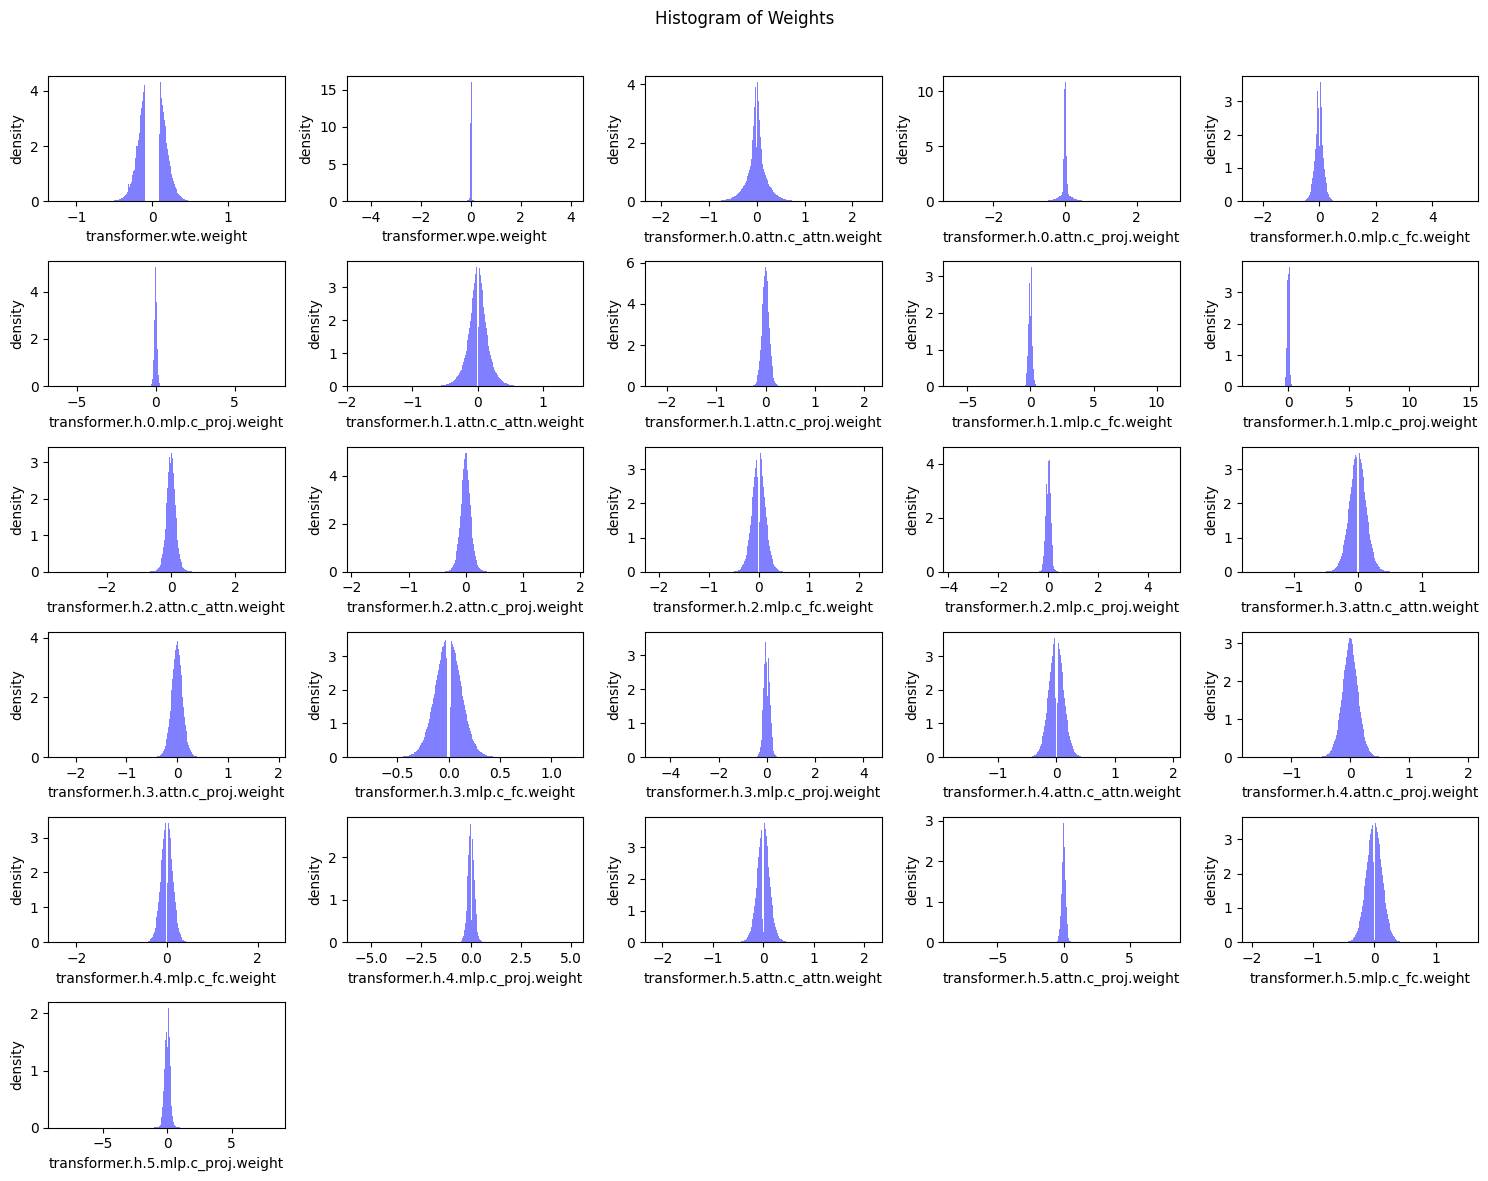

In [21]:
pruner = FineGrainedPruner(model, sparsity_dict)
print(f'After pruning with sparsity dictionary')
for name, sparsity in sparsity_dict.items():
    print(f'  {name}: {sparsity:.2f}')
print(f'The sparsity of each layer becomes')
for name, param in model.named_parameters():
    if name in sparsity_dict:
        print(f'  {name}: {get_sparsity(param):.2f}')

sparse_model_size = get_model_size(model, count_nonzero_only=True)
print(f"Sparse model has size={sparse_model_size / MiB:.2f} MiB = {sparse_model_size / model_size * 100:.2f}% of dense model size")
sparse_model_perplexity = evaluate(model, tokenizer)
print(f"Sparse model has perplexity={sparse_model_perplexity:.2f} before finetuning")
sparse_model_accuracy = evaluate_accuracy(model, tokenizer)
print(f"Sparse model has accuracy={sparse_model_accuracy:} before finetuning")

plot_weight_distribution(model, count_nonzero_only=True)

In [24]:
import copy

num_finetune_epochs = 3
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_finetune_epochs)
criterion = nn.CrossEntropyLoss()

best_sparse_model_checkpoint = dict()
best_perplexity = float("inf")

print("Finetuning Sparse Model for Perplexity Reduction")

train_data = load_dataset('wikitext', 'wikitext-2-raw-v1', split='train')
train_text = "\n\n".join(train_data['text'])
encodings = tokenizer(train_text, return_tensors='pt')

input_ids = encodings.input_ids.to(model.device)

seq_len = 1024
batch_size = 2
total_tokens = input_ids.size(1)
num_batches = max(total_tokens // (seq_len * batch_size), 1)

for epoch in range(num_finetune_epochs):
    model.train()
    total_loss = 0
    steps = 0

    for i in tqdm.tqdm(range(num_batches), desc=f"Epoch {epoch+1}/{num_finetune_epochs}"):
        start = i * seq_len * batch_size
        end = (i + 1) * seq_len * batch_size
        if end > total_tokens:
            break

        batch = input_ids[:, start:end].view(batch_size, seq_len).to(model.device)

        outputs = model(batch, labels=batch)
        loss = outputs.loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        # maintain sparsity mask if pruner exists
        if 'pruner' in locals():
            pruner.apply(model)

        total_loss += loss.item()
        steps += 1

    if steps == 0:
        print("Warning: No batches processed (increase dataset size or reduce seq_len/batch_size).")
        break

    avg_loss = total_loss / steps
    perplexity = torch.exp(torch.tensor(avg_loss))
    is_best = perplexity < best_perplexity

    if is_best:
        best_sparse_model_checkpoint['state_dict'] = copy.deepcopy(model.state_dict())
        best_perplexity = perplexity.item()

    print(f"  Epoch {epoch+1}: Perplexity {perplexity:.2f} / Best: {best_perplexity:.2f}")


Finetuning Sparse Model for Perplexity Reduction


Epoch 1/3: 100%|██████████| 1185/1185 [07:46<00:00,  2.54it/s]


  Epoch 1: Perplexity 40.26 / Best: 40.26


Epoch 2/3: 100%|██████████| 1185/1185 [07:44<00:00,  2.55it/s]


  Epoch 2: Perplexity 33.89 / Best: 33.89


Epoch 3/3: 100%|██████████| 1185/1185 [07:44<00:00,  2.55it/s]

  Epoch 3: Perplexity 31.94 / Best: 31.94


In [26]:
# load the best sparse model checkpoint to evaluate the final performance
model.load_state_dict(best_sparse_model_checkpoint['state_dict'])
sparse_model_size = get_model_size(model, count_nonzero_only=True)
print(f"Sparse model has size={sparse_model_size / MiB:.2f} MiB = {sparse_model_size / model_size * 100:.2f}% of dense model size")
sparse_model_perplexity = evaluate(model, tokenizer)
print(f"Sparse model has perplexity={sparse_model_perplexity:.2f} after finetuning")

Sparse model has size=224.00 MiB = 71.69% of dense model size


evaluating...: 100%|██████████| 40/40 [00:01<00:00, 20.29it/s]


Sparse model has perplexity=28.62 after finetuning
